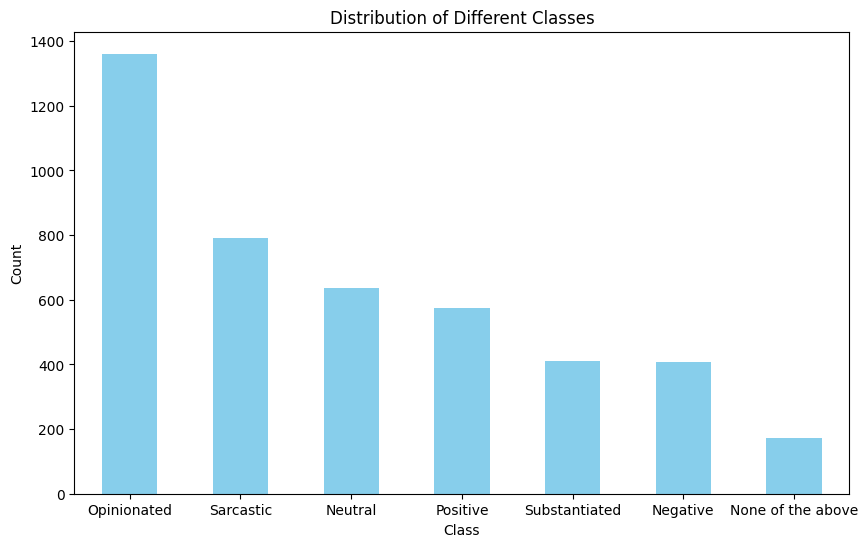

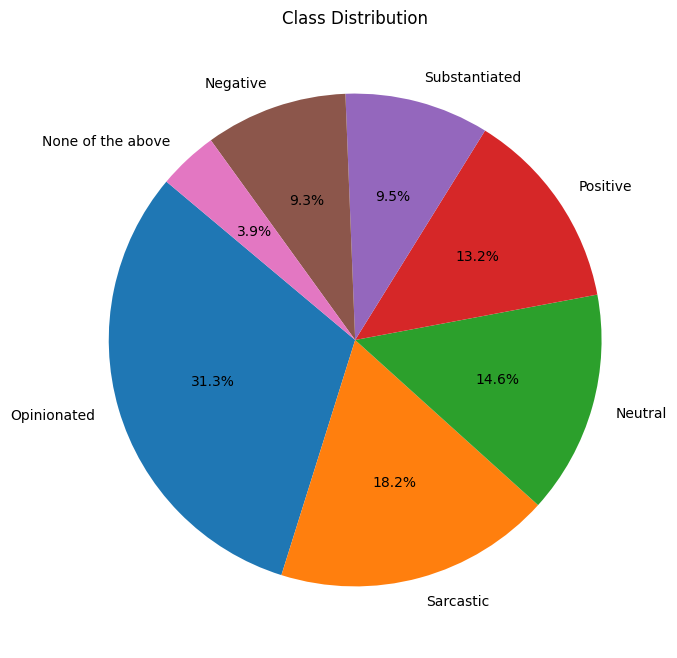

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('../Data/PS_train.csv')

class_counts = data['labels'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Different Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8, 8))
class_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()
